## Define Traffic Distributions

Factors affecting total number of demands:

- min_num_demands: Sets minimum number of demands to generate. 

- min_last_demand_arrival_time: Specifies the minimum arrival time of the final flow. The number of demands will be duplicated by TrafPy until the final flow arrives at a time >= min_last_demand_arrival_time. Higher -> must duplicate flows more times -> more demands.

- jensen_shannon_distance_threshold: Specifies the maximum acceptable Jensen Shannon distance when generating the flow size and interarrival time distributions. Must be between 0 and 1. Lower threshold -> sampled distributions must be closer to original distributions -> more demands.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
load_prev_dist=False. Will re-generate dists with given network params and override any previously saved distributions.
Generating node_dist distribution for university benchmark...
Generating flow_size_dist distribution for university benchmark...
Generating interarrival_time_dist distribution for university benchmark...


 <Figure size 640x480 with 0 Axes>]

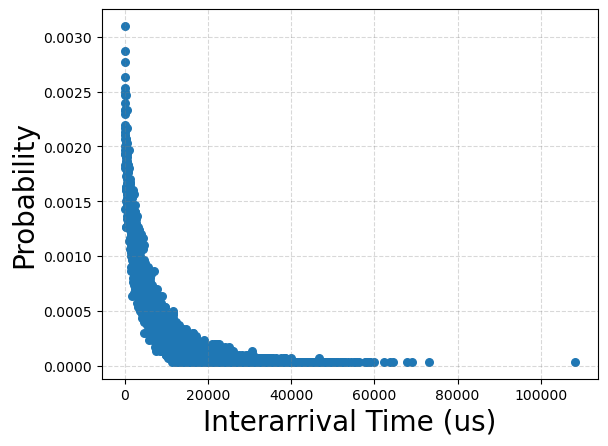

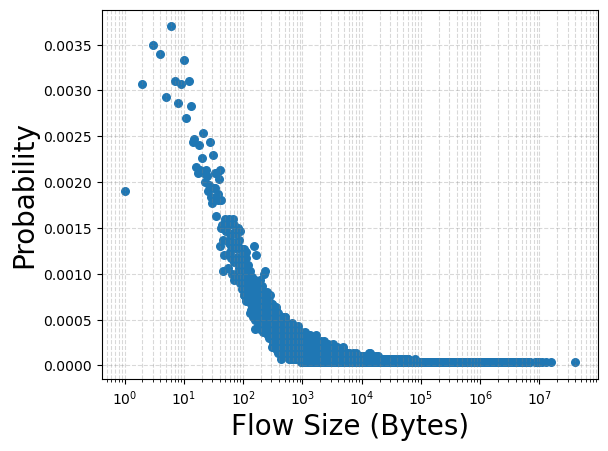

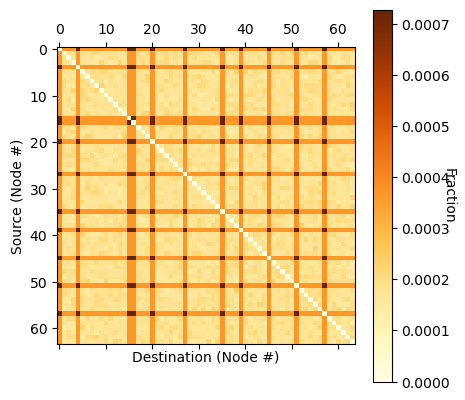

<Figure size 640x480 with 0 Axes>

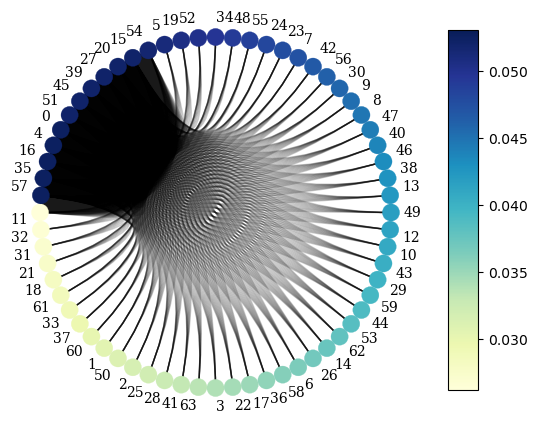

In [12]:
%load_ext autoreload
%autoreload
from trafpy.benchmarker import BenchmarkImporter
import trafpy.generator as tpg
import time
import copy
from scipy.io import savemat


# set vars
N = 64
path = r'C:/Users/benjo/Documents/Work/UCL/Workloads/'
min_num_demands = 20000
min_last_demand_arrival_time = 3
jensen_shannon_distance_threshold = 0.9
loads = [0.9]

# init network
net = tpg.gen_arbitrary_network(ep_label=None, num_eps=N, server_to_rack_channel_capacity=12500)

# set flow size, interarrival time, and node distributions
importer = BenchmarkImporter(benchmark_version='0.0.1', load_prev_dists=False)
benchmark_dists = importer.get_benchmark_dists(benchmark='university', racks_dict=None, eps=net.graph['endpoints'])
flow_size_dist, interarrival_time_dist, node_dist = benchmark_dists['flow_size_dist'], benchmark_dists['interarrival_time_dist'], benchmark_dists['node_dist']

# plot dists
tpg.plot_dict_scatter(_dict=interarrival_time_dist, marker_size=30, logscale=False, rand_var_name='Interarrival Time (us)')
tpg.plot_dict_scatter(_dict=flow_size_dist, marker_size=30, logscale=True, rand_var_name='Flow Size (Bytes)')
tpg.plot_node_dist(node_dist, chord_edge_width_range=[1,25], chord_edge_display_threshold=0.475)

## Generate Traffic Data

Generating load 0.9...
auto_node_dist_correction set to True. Adjusting node distribution to make it valid...
Generated load 0.9 in 36.771464109420776 seconds.


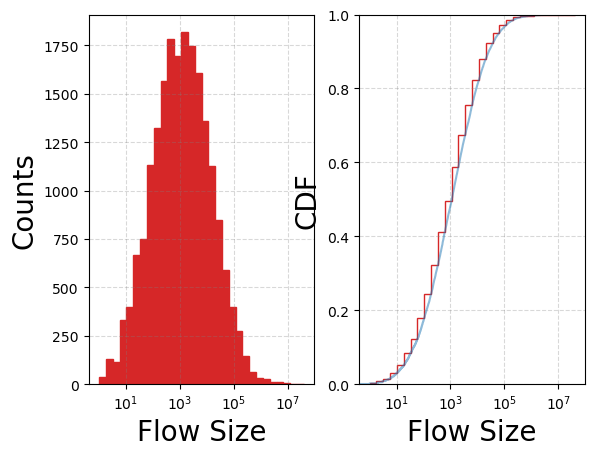

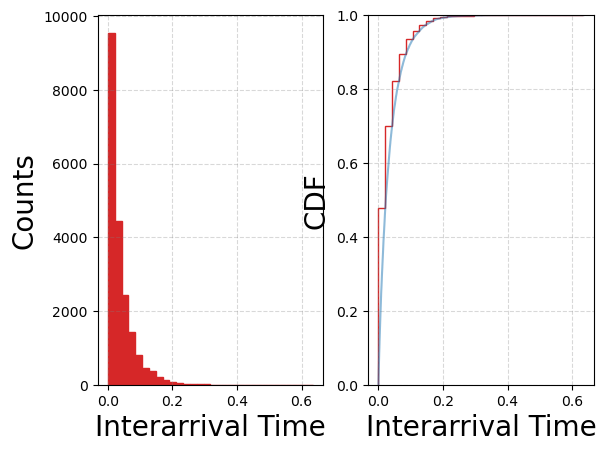

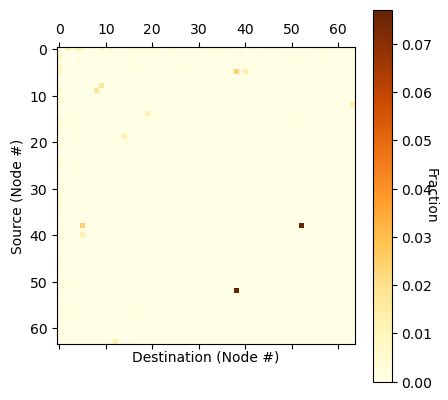

<Figure size 640x480 with 0 Axes>

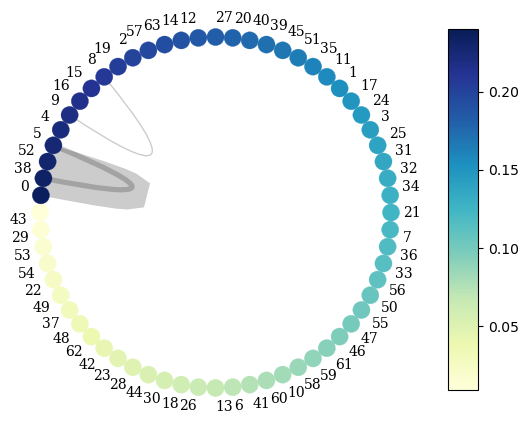

<Figure size 640x480 with 0 Axes>

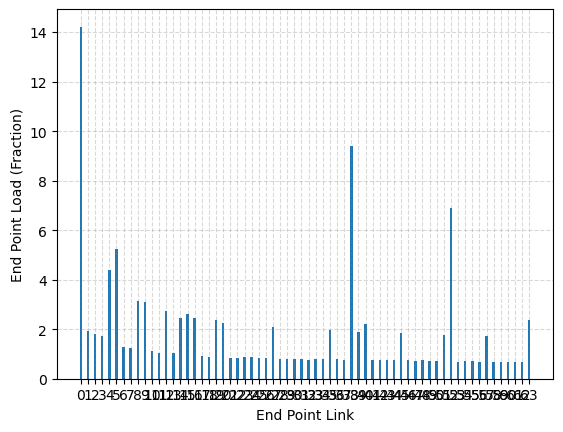

<Figure size 640x480 with 0 Axes>

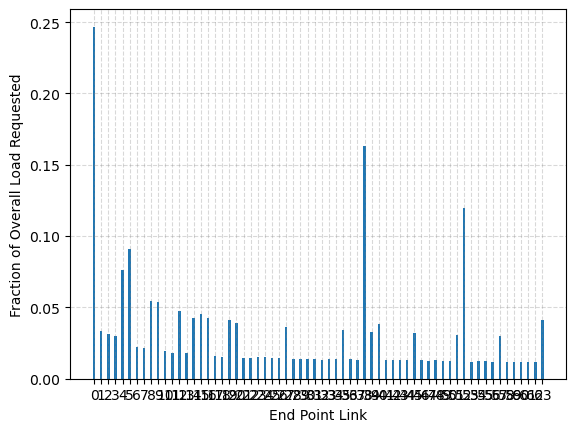

<Figure size 640x480 with 0 Axes>

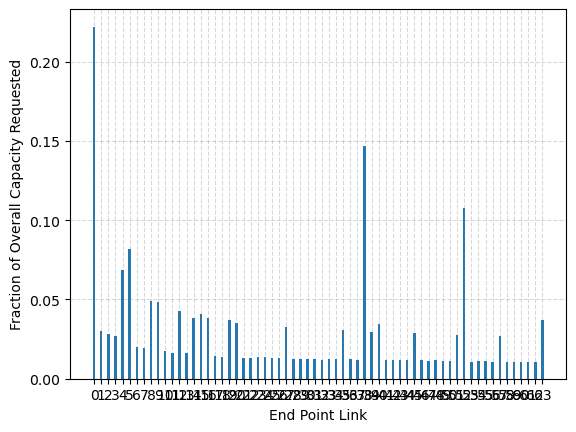

In [13]:
%autoreload
from trafpy.generator import Demand, DemandPlotter

demands = []
for load in loads:
    print('Generating load {}...'.format(load))
    
    start = time.time()
    
    # generate demands
    network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                           'ep_link_capacity': net.graph['ep_link_capacity'],
                           'target_load_fraction': load}
    flow_centric_demand_data = tpg.create_demand_data(eps=net.graph['endpoints'],
                                                      node_dist=node_dist,
                                                      flow_size_dist=flow_size_dist,
                                                      interarrival_time_dist=interarrival_time_dist,
                                                      network_load_config=network_load_config,
                                                      jensen_shannon_distance_threshold=jensen_shannon_distance_threshold,
                                                      min_num_demands=min_num_demands,
                                                      min_last_demand_arrival_time=min_last_demand_arrival_time,
                                                      check_dont_exceed_one_ep_load=False,
                                                      auto_node_dist_correction=True,
                                                      print_data=True)
    
    # plot generated demands
    demand = Demand(flow_centric_demand_data, net.graph['endpoints'])
    demands.append(demand)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, num_bins=30)
    plotter.plot_interarrival_time_dist(logscale=False, num_bins=30)
    plotter.plot_node_dist(eps=net.graph['endpoints'], chord_edge_width_range=[1,25], chord_edge_display_threshold=0.2)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=net.graph['ep_link_capacity'])
    
    # save generated demands
#     savemat("load{}_matlab_matrix.mat".format(load), flow_centric_demand_data)
    
    end = time.time()
    print('Generated load {} in {} seconds.'.format(load, end-start))

## Print Summary of Generated Traffic Data

+----+--------+---------+-------+---------+------------+-------------+--------+------------+-------------+
|    | Name   |   Flows |   1st |    Last |   Duration |        Info |   Load |   Smallest |     Largest |
|----+--------+---------+-------+---------+------------+-------------+--------+------------+-------------|
|  0 | demand |   20000 |     0 | 728.943 |    728.943 | 5.24839e+08 | 720000 |          1 | 4.04868e+07 |
+----+--------+---------+-------+---------+------------+-------------+--------+------------+-------------+


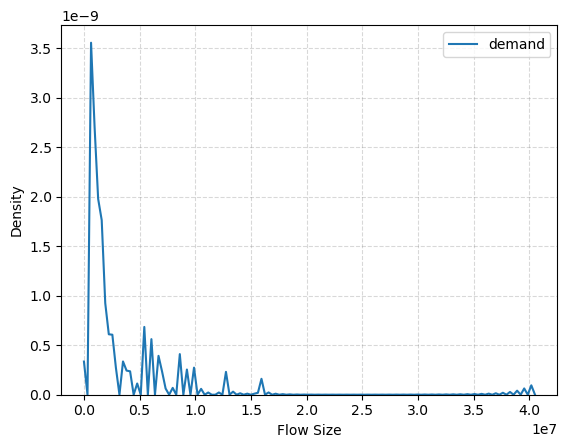

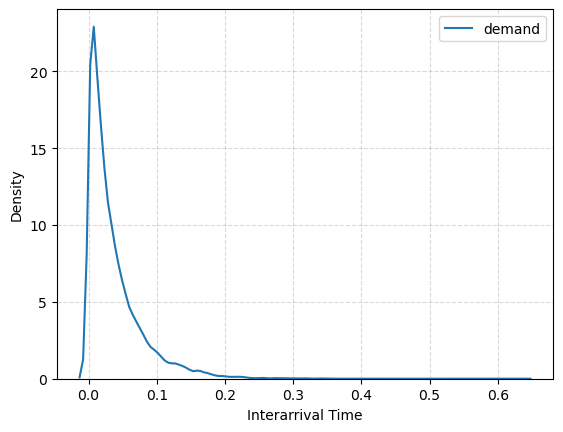

In [14]:
%autoreload
from trafpy.generator import DemandsAnalyser, DemandsPlotter

# print analysis of generated demand(s)
analyser = DemandsAnalyser(*demands)
analyser.compute_metrics(print_summary=True)

# plot composite of generated flow size and interarrival time dists
plotters = DemandsPlotter(*demands)
_ = plotters.plot_flow_size_dists(logscale=False)
_ = plotters.plot_interarrival_time_dists(logscale=False)